In [2]:
import numpy as np
import jax
import jax.numpy as jnp

import optax
import corner
import matplotlib.pyplot as plt

from functools import partial
import jimgw

import distrax
import haiku as hk     
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple
Array = jnp.ndarray
PRNGKey = Array
OptState = Any


In [3]:

#Normalising flow

def make_conditioner(
    event_shape: Sequence[int],
    hidden_sizes: Sequence[int],
    num_bijector_params: int
) -> hk.Sequential:
  """Creates an."""
  return hk.Sequential([
      hk.Flatten(preserve_dims=-len(event_shape)),
      hk.nets.MLP(hidden_sizes, activate_final=True),
      # We initialize this linear layer to zero so that the flow is initialized
      # to the identity function.
      hk.Linear(
          np.prod(event_shape) * num_bijector_params,
          w_init=jnp.zeros,
          b_init=jnp.zeros),
      hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
  ])

def make_flow_model(
    event_shape: Sequence[int],
    num_layers: int = 4,
    hidden_sizes: Sequence[int] = [250, 250],
    num_bins: int = 4,
) -> distrax.Transformed:
    """Creates the flow model."""
    # Alternating binary mask.
    mask = np.arange(0, np.prod(event_shape)) % 2
    mask = np.reshape(mask, event_shape)
    mask = mask.astype(bool)

    def bijector_fn(params: Array):
        return distrax.RationalQuadraticSpline(
            params, range_min=-1., range_max=1.
        )

    # Number of parameters for the rational-quadratic spline:
    # - `num_bins` bin widths
    # - `num_bins` bin heights
    # - `num_bins + 1` knot slopes
    # for a total of `3 * num_bins + 1` parameters.
    num_bijector_params = 3 * num_bins + 1

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            conditioner=make_conditioner(event_shape, hidden_sizes,
                                        num_bijector_params))
        layers.append(layer)
        # Flip the mask after each layer.
        mask = jnp.logical_not(mask)

    # We invert the flow so that the `forward` method is called with `log_prob`.
    flow = distrax.Inverse(distrax.Chain(layers))                                   #bijective transformation from base (normal) to parameter space 
    base_distribution = distrax.Independent(
        distrax.Uniform(low=jnp.ones(event_shape)*-1, high=jnp.ones(event_shape)*1),
        #distrax.Normal(loc=jnp.zeros(event_shape), scale=jnp.ones(event_shape)),
        reinterpreted_batch_ndims=len(event_shape)
    )

    return distrax.Transformed(base_distribution, flow)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


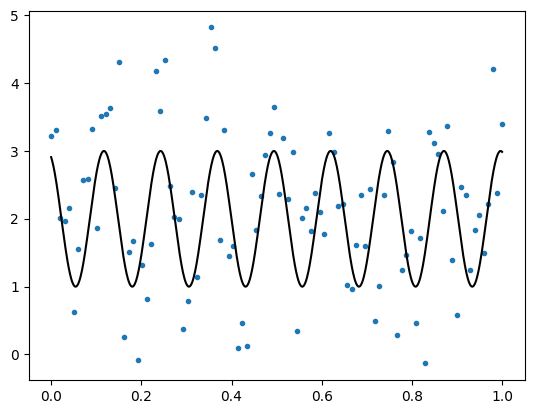

Array(-40.995262, dtype=float32)

In [4]:
def model_sine(x, a, b, c):        #data model with parameters theta=(a,b,c)
    return a*jnp.sin(50*x+b)+c

def simulate_data(model, theta, sigma_noise, n_data_points):
    x_vec = jnp.linspace(0, 1, n_data_points)
    return model(x_vec, *theta) + np.random.normal(0, sigma_noise, n_data_points)

theta = [1, 2, 2]

def log_L(theta, data, sigma_noise, n_data_points):
    x_vec = np.linspace(0, 1, n_data_points)
    model=model_sine(x_vec, *theta)
    return -1/2*sigma_noise**2 * np.sum((data-model)**2)

x_vec = np.linspace(0, 1, 100)
x_vec_2 = np.linspace(0, 1, 1000)
data = simulate_data(model_sine, theta, 1, 100)
theory = model_sine(x_vec_2, *theta) 
plt.plot(x_vec, data, '.')  
plt.plot(x_vec_2, theory, '-k')    
plt.show()

log_L(theta, data, 1, 100)


In [5]:
log_L([1,2,2], data, 1, 100)

Array(-40.995262, dtype=float32)

In [6]:
#@jax.jit

# likelihood function
class LogL(object):
    true_gw_params = dict(
        A=0.3,
        B=0.8,
        C=0.2
    )
    
    def __init__(self, T = 1):
        true_gw_params = self.true_gw_params

        # simulate data
        #T = 1 # duration of analysis segment
        #srate = 20
        #df = 1/T
        #freqs = jnp.arange(1+srate*T, dtype=jnp.float32)*df
        #f0 = 100
        #Nbins = 1
        #i0 =int(f0/df)
        #self.freqs = jnp.atleast_2d(freqs[i0])

        self.beta = 1/T
        self.data = simulate_data(model_sine, [true_gw_params['A'],true_gw_params['B'], true_gw_params['C']], sigma_noise=1, n_data_points=1000)
        self.bounds = dict(
            A = [0.,2.],
            B = [-jnp.pi, jnp.pi],
            C = [-2., 2.],
        )

    
    def __call__(self, gw_params):
        x_vec = np.linspace(0, 1, 1000)
        residuals = jnp.array(self.data-model_sine(x_vec, gw_params['A'], gw_params['B'], gw_params['C']))
        sigma_noise=1.
        
        return -1/(2*sigma_noise**2) *jnp.sum(residuals**2)
    
    @property
    def gw_params(self):
        gw_params = ['A','B','C']
        return gw_params


    #@jax.jit  WTFFFF  are these weighted by priors....??????? or reparametrised? ----> Effectively transforming the domain
    def array_to_phys(self, x: Array) -> dict:
        p = dict()
        p['A']=x[:,0]+1  #0 to 2 uniform                        
        p['B']=x[:,1]*jnp.pi   #-pi to pi
        p['C']=x[:,2]*2      #-2 to 2

        #p['A'] = self.true_params['A'] * jnp.exp(x[:,0])
        #p['phi'] = x[:,1]*jnp.pi
        #p['dec'] = jnp.pi/2 - jnp.arccos(x[:,2])
        #p['ra'] = (x[:,3]+1)*jnp.pi
        #p['psi'] = 0.5*jnp.pi*(x[:,4])
        return p




In [7]:
#Neural network setup

@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )
    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))
     # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of th sampled points)


def log_likelihood(x: Array) -> Array:      #transform to parameter space before c
    p = log_l.array_to_phys(x)
    return log_l(p)

def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    log_p = log_likelihood(x_flow)                                           #gets gw loglikelihood for the sampled points (after transforming them into physical space..)

    # int Q \log (Q / P)
    # x \sim Q
    # mean(log (Q / P))
    loss = jnp.mean(log_q - log_p)
    return loss

@jax.jit
def update(
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps)
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


Simulated data:  [ 1.58018029e+00  1.06645012e+00  2.00412464e+00  2.30609894e-01
  9.67239380e-01  2.03729606e+00  7.00961471e-01  2.06569910e+00
  2.55777907e+00  3.43960166e+00  2.18096018e+00  1.21940708e+00
  2.22618890e+00  3.47065878e+00  1.30590212e+00  6.75286889e-01
  1.99630201e+00  2.19270706e+00  1.66528392e+00  3.00833035e+00
  2.51579046e+00  2.60592747e+00  6.10440373e-01  1.31421530e+00
  1.57691109e+00  1.93359041e+00 -2.16856956e-01 -1.32424235e-01
  7.73583412e-01  1.60902405e+00  1.17957091e+00  1.72301531e+00
  2.34316921e+00  1.39942372e+00  2.46812439e+00  6.69462681e-02
  1.09526694e+00 -1.46520972e+00  1.55001175e+00  2.21603811e-01
  1.90420079e+00  5.19210041e-01  2.62103987e+00  8.28664780e-01
  8.14075470e-01  2.61177254e+00  9.53172207e-01  2.71825492e-01
  2.82531381e-01  7.01980472e-01  2.03533143e-01 -4.59978700e-01
 -5.69250286e-01 -1.54747403e+00 -4.92436290e-02 -7.78479218e-01
 -7.11120129e-01  7.93167949e-01  2.98341393e-01  6.64218664e-02
 -2.3219

  0%|          | 0/1000 [00:00<?, ?it/s, loss=3503.90, T=10.00]

Epoch 0, loss 3503.903564453125


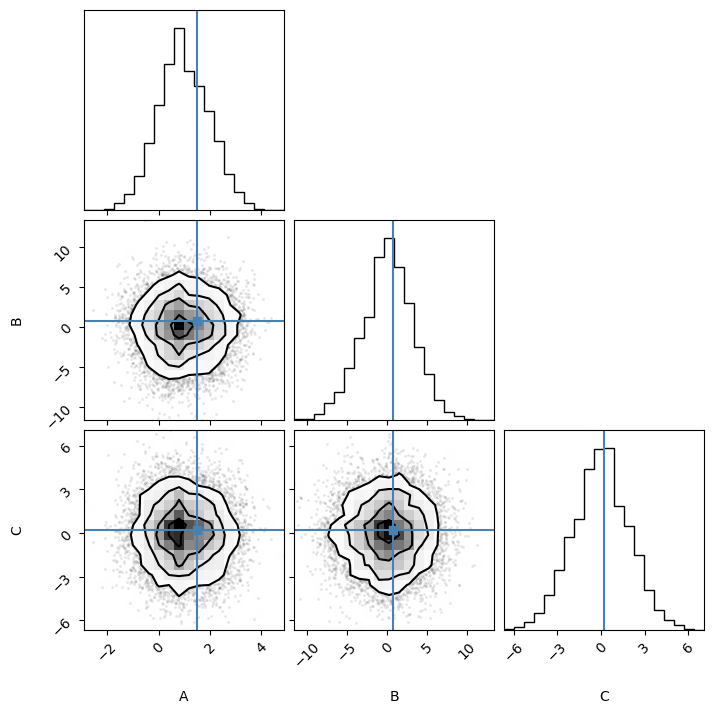

  5%|▌         | 50/1000 [00:25<04:35,  3.45it/s, loss=1557.23, T=1.00]  

Epoch 50, loss 1557.2291259765625


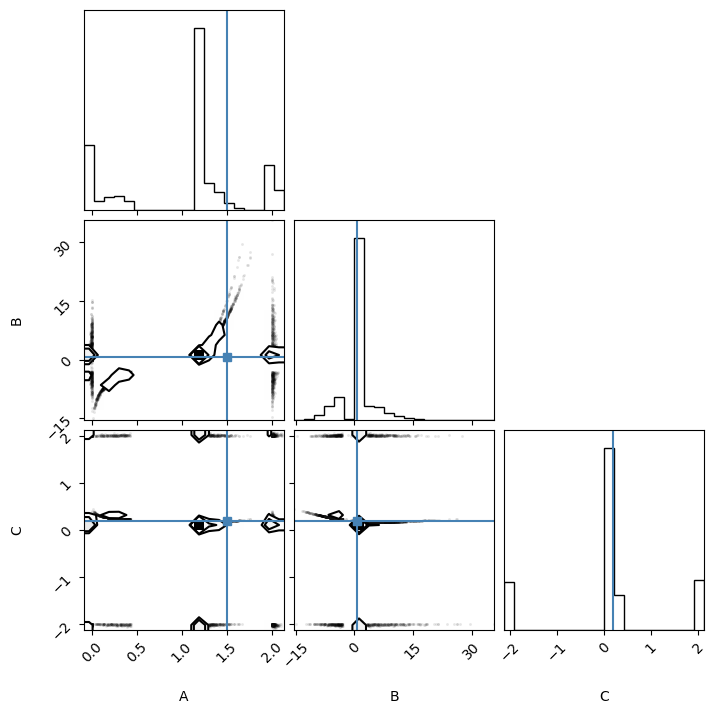

 10%|█         | 100/1000 [00:40<04:15,  3.53it/s, loss=1434.87, T=1.00]

Epoch 100, loss 1434.8680419921875


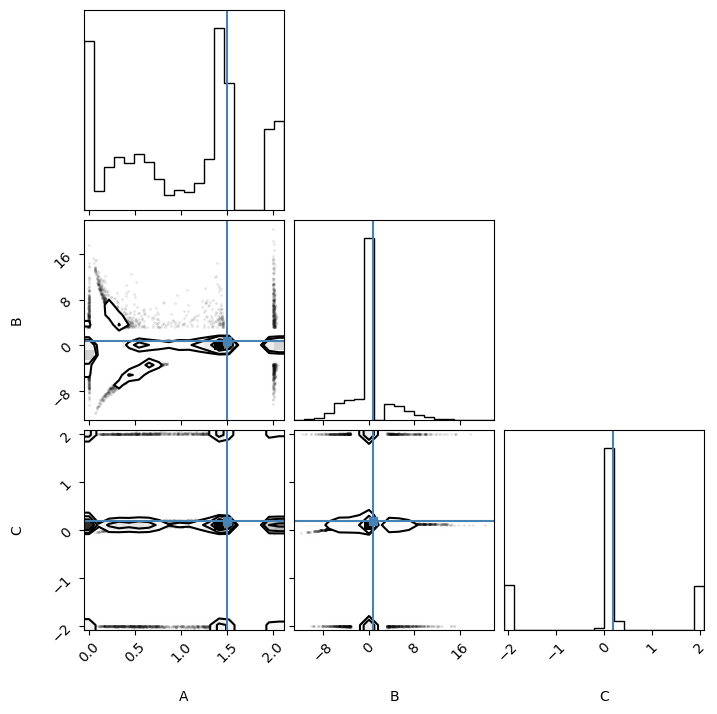

 15%|█▌        | 150/1000 [00:55<04:06,  3.44it/s, loss=1481.29, T=1.00]

Epoch 150, loss 1481.28759765625


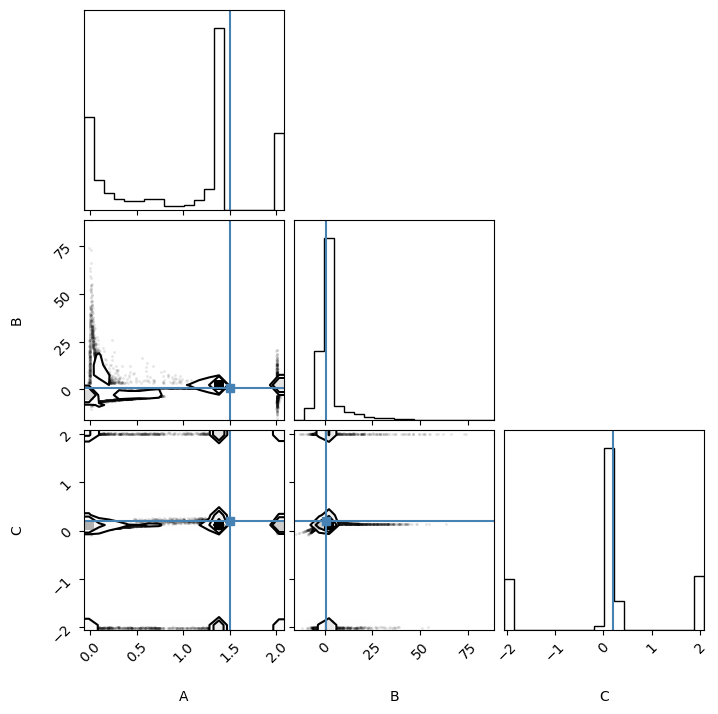

 20%|██        | 200/1000 [01:11<03:53,  3.43it/s, loss=1505.01, T=1.00]

Epoch 200, loss 1505.009521484375


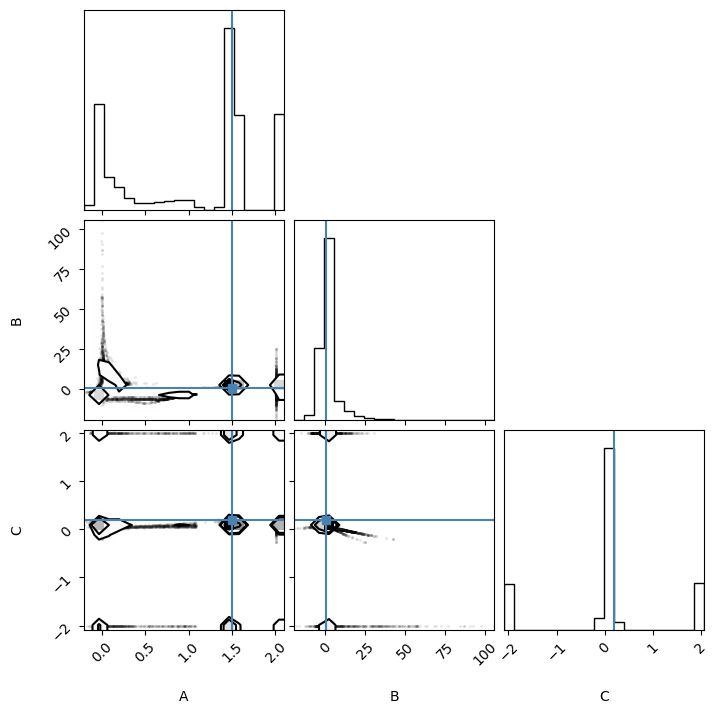

 25%|██▌       | 250/1000 [01:26<03:34,  3.50it/s, loss=1444.74, T=1.00]

Epoch 250, loss 1444.7398681640625


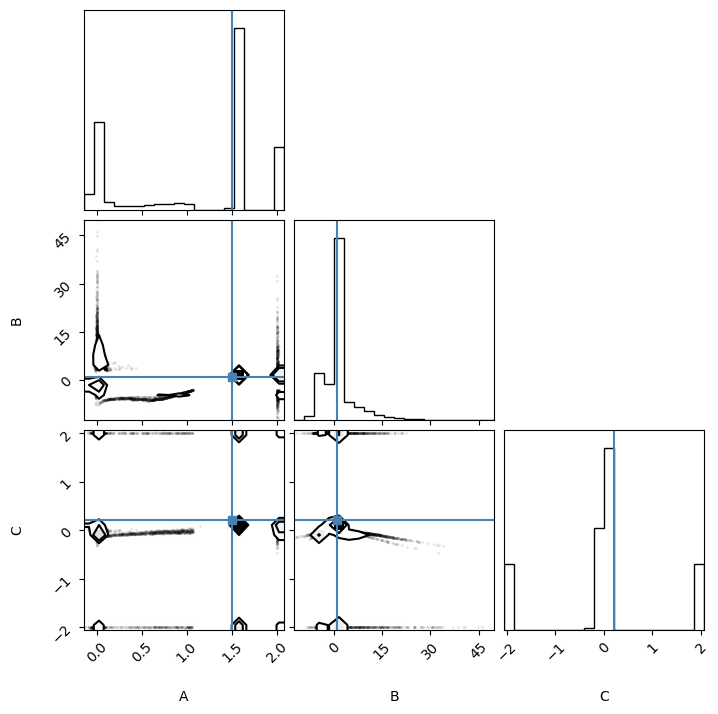

 27%|██▋       | 271/1000 [01:33<04:10,  2.91it/s, loss=1413.42, T=1.00]


KeyboardInterrupt: 

In [8]:
if __name__ == '__main__':


    


    log_l = LogL(T=1)              
    

    print('Simulated data: ',log_l.data)

    # Test likelihood
    l = log_l(log_l.true_gw_params)
    print(f'log likelihood of true params = {l}')

    n_params = len(log_l.gw_params)
    flow_num_layers = 4
    hidden_size = 16
    mlp_num_layers = 2
    num_bins = 4


    # perform variational inference
    epochs = 1000
    loss = dict(train=[], val=[])
    Nsamps = 1000

    learning_rate = 0.01
    optimiser = optax.adam(learning_rate)              #stochastic gradient descent 

    prng_seq = hk.PRNGSequence(42)
    key = next(prng_seq)
    params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
    opt_state = optimiser.init(params)

    from tqdm import tqdm, trange
    T0 = 10
    t_decay = epochs/(1+jnp.log(T0))
    ldict = dict(loss = 0, T=T0)
    annealing_stop =0
    with trange(epochs) as tepochs:
        for epoch in tepochs:
            if epoch > annealing_stop:
                T=1
            else:
                T = max(T0*jnp.exp(-epoch/t_decay),1.0)
            log_l.beta = 1/T
            ldict['T'] = f'{T:.2f}'
            prng_key = next(prng_seq)
            loss = loss_fn(params,  prng_key, Nsamps)
            ldict['loss'] = f'{loss:.2f}'
            tepochs.set_postfix(ldict, refresh=True)
            params, opt_state = update(params, prng_key, opt_state)        #take a step in direction of stepest descent (negative gradient)
            if epoch%50 == 0:
                print(f'Epoch {epoch}, loss {loss}')
                x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
                x_gen = np.array(x_gen, copy=False)
                p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
                truths = [log_l.true_gw_params[n] for n in ['A','B','C']]
                fig = corner.corner(p_gen.T, labels = log_l.gw_params, truths = truths)
                plt.show()

    print("Done!")

    x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)

    x_gen = np.array(x_gen, copy=False)
    p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
    truths = [log_l.true_gw_params[n] for n in ['A','B','C']]
    fig = corner.corner(p_gen.T, labels = log_l.gw_params, truths = truths)
    plt.show()
    plt.savefig(f'posterior_${epochs}.png')

In [ ]:
x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 1000*Nsamps)

x_gen = np.array(x_gen, copy=False)
p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
truths = [log_l.true_params[n] for n in ['A','B','C']]
fig = corner.corner(p_gen.T, labels = log_l.params, truths = truths)
plt.show()


In [ ]:
x_gen